In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from src.data import make_dataset, data_helpers
import polyline
import pandas as pd
import networkx as nx


(strava_data, drive_morning, drive_evening) = make_dataset.load_data()

In [2]:
pl = polyline.decode(strava_data['map'][2]["summary_polyline"])
pl2 = polyline.decode(strava_data['map'][6]["summary_polyline"])
pl3 = polyline.decode(strava_data['map'][1]["summary_polyline"])

In [3]:
distance, path = fastdtw(pl, pl2, dist=euclidean)

In [4]:
distance2, path2 = fastdtw(pl, pl3, dist=euclidean)

In [5]:
distance

0.1984498796708359

In [6]:
distance2

0.006995446412780337

In [7]:
def get_start_latlng(mp):
    pl = mp['summary_polyline']
    if pl:
        return(polyline.decode(pl)[0])
    
def get_end_latlng(mp):
    pl = mp['summary_polyline']
    if pl:
        return(polyline.decode(pl)[-1])

In [8]:
strava_data['start_latlng'] = strava_data['map'].apply(get_start_latlng)
strava_data['end_latlng'] = strava_data['map'].apply(get_end_latlng)
strava_data[['start_lat', 'start_lng']] = strava_data['start_latlng'].apply(pd.Series)
strava_data[['end_lat', 'end_lng']] = strava_data['end_latlng'].apply(pd.Series)

In [9]:
from sklearn.cluster import DBSCAN
(morning_commutes, evening_commutes) = data_helpers.split_morning_evening(strava_data)

In [10]:
def get_polylines(df, pls):
    for (index, row) in df.iterrows():
        if (row['map']['summary_polyline']):
            pl = polyline.decode(row['map']['summary_polyline'])
            pls.append(pl)
    return pls


In [46]:
def fast_dtw_from_indices(a, b):
    pl = polyline.decode(strava_data['map'][a]["summary_polyline"])
    pl2 = polyline.decode(strava_data['map'][b]["summary_polyline"])
    distance, _ = fastdtw(pl, pl2)
    return distance

In [92]:
def make_adjacency_matrix(df):
    indices = np.array(df.index)
    DD = np.zeros(shape=(len(indices), len(indices)))
    for i in range(0, len(indices)):
        for j in range(0, len(indices)):
            DD[i, j] = fast_dtw_from_indices(indices[i], indices[j])
    return DD

In [98]:
DD = make_adjacency_matrix(evening_commutes)
G = nx.from_numpy_matrix(DD)

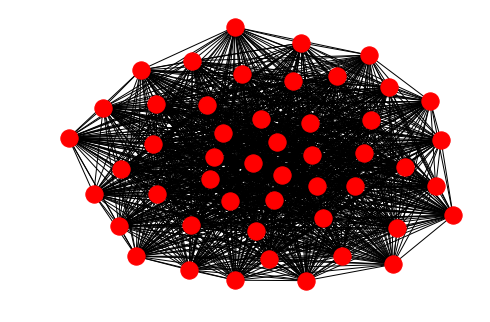

In [99]:
networkx.draw(G)

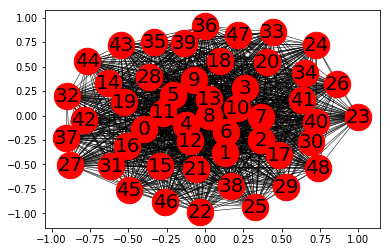

In [100]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=G.edges,
                    width=.5)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif');

In [ ]:
#https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8
#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html]\t